In [1]:
from PIL import Image
import numpy as np
from skimage import color
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from Kriging import *
import time
import skimage
from Kriging import *
import skimage
from skimage.filters import threshold_multiotsu
from DL import *

In [2]:
Image.MAX_IMAGE_PIXELS = 10**9

img = np.array(Image.open('../data/273.tif'))
img_layers = np.array(Image.open('../data/273-colour.png'))

[[204   0   0]]
[[255 102   0]]
[[255 204   0]]
[[  0 204   0]]
[[ 51 102 204]]
[[0 0 0]]


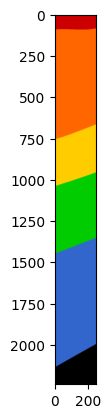

In [3]:
regions = [
    [(2960, 3045), (7000, 7212)],
    [(3100, 3200), (7000, 7250)],
    [(3800, 3900), (7000, 7250)],
    [(4100, 4200), (7000, 7250)],
    [(4500, 4600), (7000, 7250)],
    [(5100, 5200), (7000, 7250)]
]

for i in range(6):
    r = regions[i]
    print(np.unique(img_layers[r[0][0]:r[0][1], r[1][0]:r[1][1]].reshape(-1, 3), axis=0))

plt.imshow(img_layers[2960:5200, 7000:7250])

In [4]:
def seg_2dmrk(img_partial):
    im = (color.rgb2gray(img_partial)*256).astype('uint8')
    im = skimage.exposure.adjust_sigmoid(im, cutoff=0.3)    # Emphasise mid range to remove noise
    im = skimage.exposure.rescale_intensity(im) # Increase contrast

    im = np.expand_dims(im, axis=0)

    tdmrk = TwoDimMultiRegionKriging(img_full=im, # Path to image
                                    n_clusters=4, # Number of clusters
                                    max_iter_uncertain=10, # Max num of iterations to find uncertain region(s)
                                    zeta0=1.96, # Uncertainty factor
                                    p_uncertain=0.12, # Desired uncertainty region probability
                                    vario_distance=30, # Max distance on semivariogram
                                    krig_win_radius=3) # Kriging window radius

    st = time.time()
    tdmrk.train()
    print(f'Completed training in {time.time()-st:.2f} seconds.')

    st = time.time()
    out = tdmrk.infer(0)
    print(f'Completed slice {0} in {time.time()-st:.2f} seconds.')

    return out

def seg_dk(img_partial):
    im = (color.rgb2gray(img_partial)*256).astype('uint8')
    im = skimage.exposure.adjust_sigmoid(im)    # Emphasise mid range to remove noise
    im = skimage.exposure.rescale_intensity(im) # Increase contrast

    im = np.expand_dims(im, axis=0)

    dk = DeepKriging(img_full=im, # Image data
                    n_clusters=4, # Number of clusters
                    max_iter_uncertain=10, # Max num of iterations to find uncertain region(s)
                    zeta0=1.96, # Uncertainty factor
                    p_uncertain=0.12, # Desired uncertainty region probability
                    n_epochs=20, # Number of epochs for training neural network
                    batch_size=32) # Batch size for training data
    
    st = time.time()
    dk.train()
    print(f'Completed training in {time.time()-st:.2f} seconds.')

    st = time.time()
    out = dk.infer(0)
    print(f'Completed slice {0} in {time.time()-st:.2f} seconds.')

    return out

def seg_dl(img_partial):
    im = (color.rgb2gray(img_partial)*256).astype('uint8')
    im = skimage.exposure.adjust_sigmoid(im, cutoff=0.3)    # Emphasise mid range to remove noise
    im = skimage.exposure.rescale_intensity(im) # Increase contrast

    im = np.expand_dims(im, axis=0)

    us = UnsupervisedSegmentation(img_full=im, # Image data
                                  n_iterations=20, # Number of iterations/epochs for training
                                  lr=0.01, # Learning rate for training
                                  n_conv=2) # Number of convolutional layers in CNN

    us.prepare_slice(0)
    us.train()
    final_segmentation = us.infer()

    return final_segmentation

def seg_otsu(img_partial):
    im = (color.rgb2gray(img_partial)*256).astype('uint8')
    im = skimage.exposure.adjust_sigmoid(im, cutoff=0.3)    # Emphasise mid range to remove noise
    im = skimage.exposure.rescale_intensity(im) # Increase contrast

    im = np.expand_dims(im, axis=0)

    thresholds = threshold_multiotsu(im[0], classes=4)
    regions = np.digitize(im, bins=thresholds)

    return regions[0]

[0. 0. 0.] [0. 0. 0.]
Completed training in 0.73 seconds.
Completed slice 0 in 0.18 seconds.
[0. 0. 0.] [0. 0. 0.]
Completed training in 0.88 seconds.
Completed slice 0 in 0.22 seconds.
[0. 0. 0.] [0. 0. 0.]
Completed training in 0.95 seconds.
Completed slice 0 in 0.22 seconds.
[  0.   0. 243.] [  0.   0. 249.]
Completed training in 0.88 seconds.
Completed slice 0 in 0.55 seconds.
[  0. 230.   0.] [  0. 238.   0.]
Completed training in 0.91 seconds.
Completed slice 0 in 0.42 seconds.
[ 0.  0. 99.] [  0.   0. 221.]
Completed training in 0.85 seconds.
Completed slice 0 in 0.58 seconds.


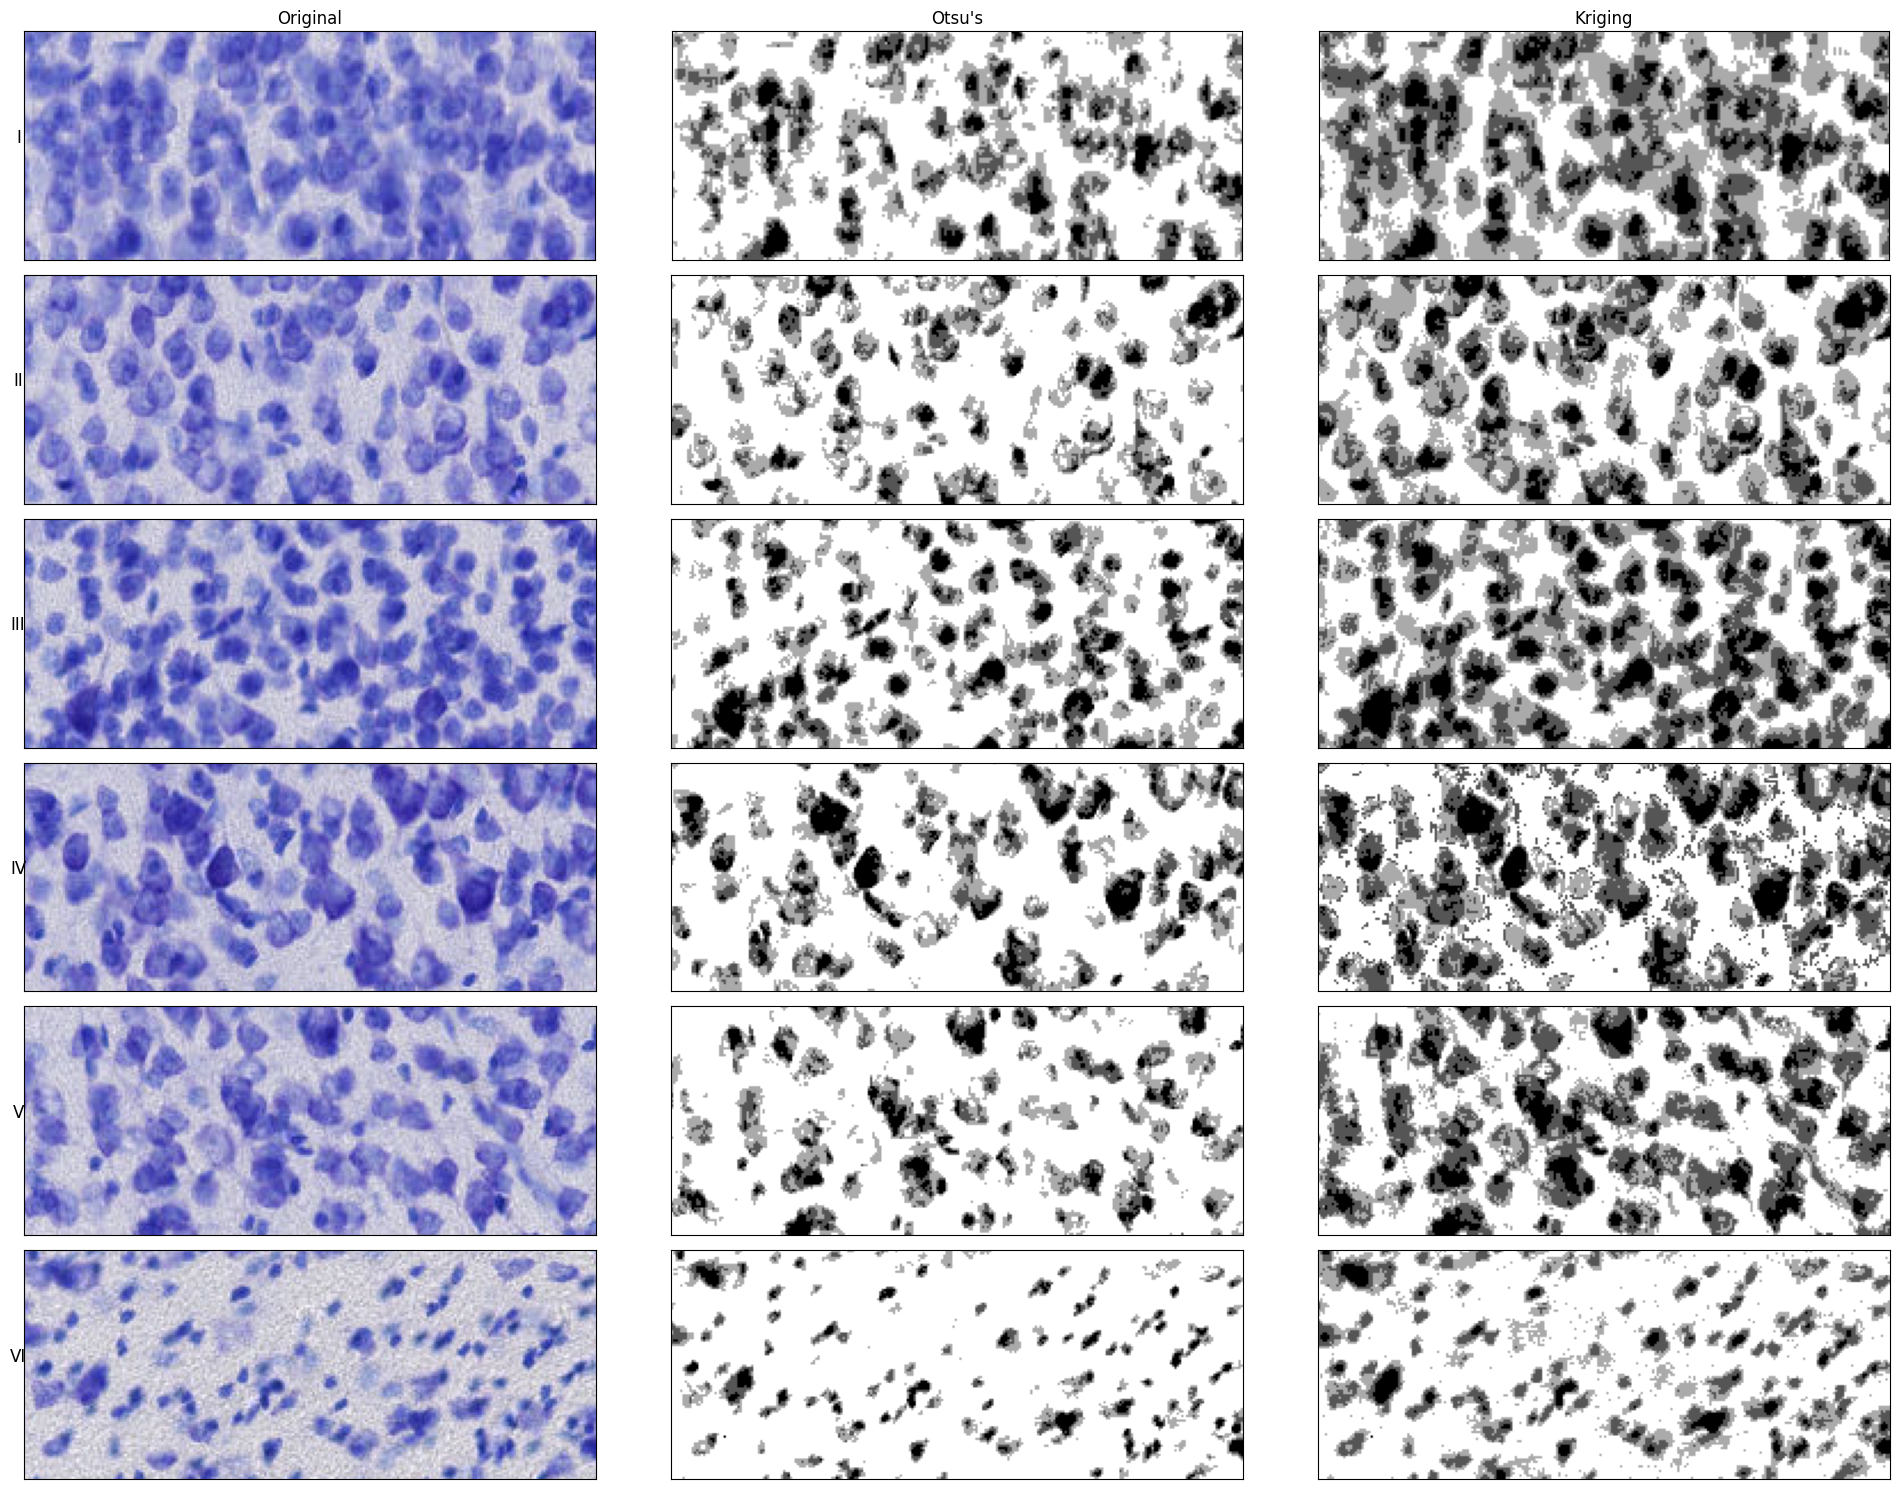

In [5]:
figs, axes = plt.subplots(6, 3, figsize=(20, 15))
plt.setp(axes, xticks=[], yticks=[])

axes[0, 0].set_title('Original')
axes[0, 1].set_title('Otsu\'s')
axes[0, 2].set_title('Kriging')

axes[0, 0].set_ylabel('I', rotation=0, size='large')
axes[1, 0].set_ylabel('II', rotation=0, size='large')
axes[2, 0].set_ylabel('III', rotation=0, size='large')
axes[3, 0].set_ylabel('IV', rotation=0, size='large')
axes[4, 0].set_ylabel('V', rotation=0, size='large')
axes[5, 0].set_ylabel('VI', rotation=0, size='large')

for i in range(6):
    r = regions[i]
    axes[i, 0].imshow(img[r[0][0]:r[0][1], r[1][0]:r[1][1]])

for i in range(6):
    r = regions[i]
    axes[i, 1].imshow(seg_otsu(img[r[0][0]:r[0][1], r[1][0]:r[1][1]]), cmap='gray')

for i in range(6):
    r = regions[i]
    axes[i, 2].imshow(seg_2dmrk(img[r[0][0]:r[0][1], r[1][0]:r[1][1]]), cmap='gray')

figs.tight_layout()

/home/ian/CS 789/.venv/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


1 / 20  | loss : 4.068819999694824
2 / 20  | loss : 3.98551082611084
3 / 20  | loss : 3.866107940673828
4 / 20  | loss : 3.7514395713806152
5 / 20  | loss : 3.656243085861206
6 / 20  | loss : 3.5791056156158447
7 / 20  | loss : 3.5028634071350098
8 / 20  | loss : 3.4329793453216553
9 / 20  | loss : 3.3673593997955322
10 / 20  | loss : 3.3054332733154297
11 / 20  | loss : 3.245755434036255
12 / 20  | loss : 3.1893486976623535
13 / 20  | loss : 3.135686159133911
14 / 20  | loss : 3.0827138423919678
15 / 20  | loss : 3.030106544494629
16 / 20  | loss : 2.979739189147949
17 / 20  | loss : 2.931985855102539
18 / 20  | loss : 2.884152889251709
19 / 20  | loss : 2.8347744941711426
20 / 20  | loss : 2.7858810424804688


/home/ian/CS 789/.venv/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


1 / 20  | loss : 4.122460842132568
2 / 20  | loss : 4.01835823059082
3 / 20  | loss : 3.8947083950042725
4 / 20  | loss : 3.780912399291992
5 / 20  | loss : 3.6716723442077637
6 / 20  | loss : 3.566317558288574
7 / 20  | loss : 3.467027187347412
8 / 20  | loss : 3.3877835273742676
9 / 20  | loss : 3.320924997329712
10 / 20  | loss : 3.2487998008728027
11 / 20  | loss : 3.181882858276367
12 / 20  | loss : 3.1219682693481445
13 / 20  | loss : 3.0668978691101074
14 / 20  | loss : 3.0120396614074707
15 / 20  | loss : 2.9592695236206055
16 / 20  | loss : 2.906522750854492
17 / 20  | loss : 2.8548617362976074
18 / 20  | loss : 2.803922176361084
19 / 20  | loss : 2.7517595291137695
20 / 20  | loss : 2.70041561126709
1 / 20  | loss : 4.0462446212768555
2 / 20  | loss : 3.9430627822875977
3 / 20  | loss : 3.8252854347229004
4 / 20  | loss : 3.7188844680786133
5 / 20  | loss : 3.6092417240142822
6 / 20  | loss : 3.5070834159851074
7 / 20  | loss : 3.4131627082824707
8 / 20  | loss : 3.3213758468

100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Completed training in 21.42 seconds.
Completed slice 0 in 0.08 seconds.
[229.   0.  63.] [237.   0.  92.]


100%|██████████| 20/20 [00:17<00:00,  1.18it/s]


Completed training in 25.69 seconds.
Completed slice 0 in 0.10 seconds.
[  0. 139.   0.] [  0. 162.   0.]


100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


Completed training in 39.27 seconds.
Completed slice 0 in 0.08 seconds.
[  0.   0. 137.] [  0.   0. 161.]


100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


Completed training in 25.72 seconds.
Completed slice 0 in 0.08 seconds.
[  0. 161.   0.] [  0. 181.   0.]


100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Completed training in 28.77 seconds.
Completed slice 0 in 0.07 seconds.
[ 0. 90.  0.] [  0. 172.   0.]


100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Completed training in 28.17 seconds.
Completed slice 0 in 0.09 seconds.


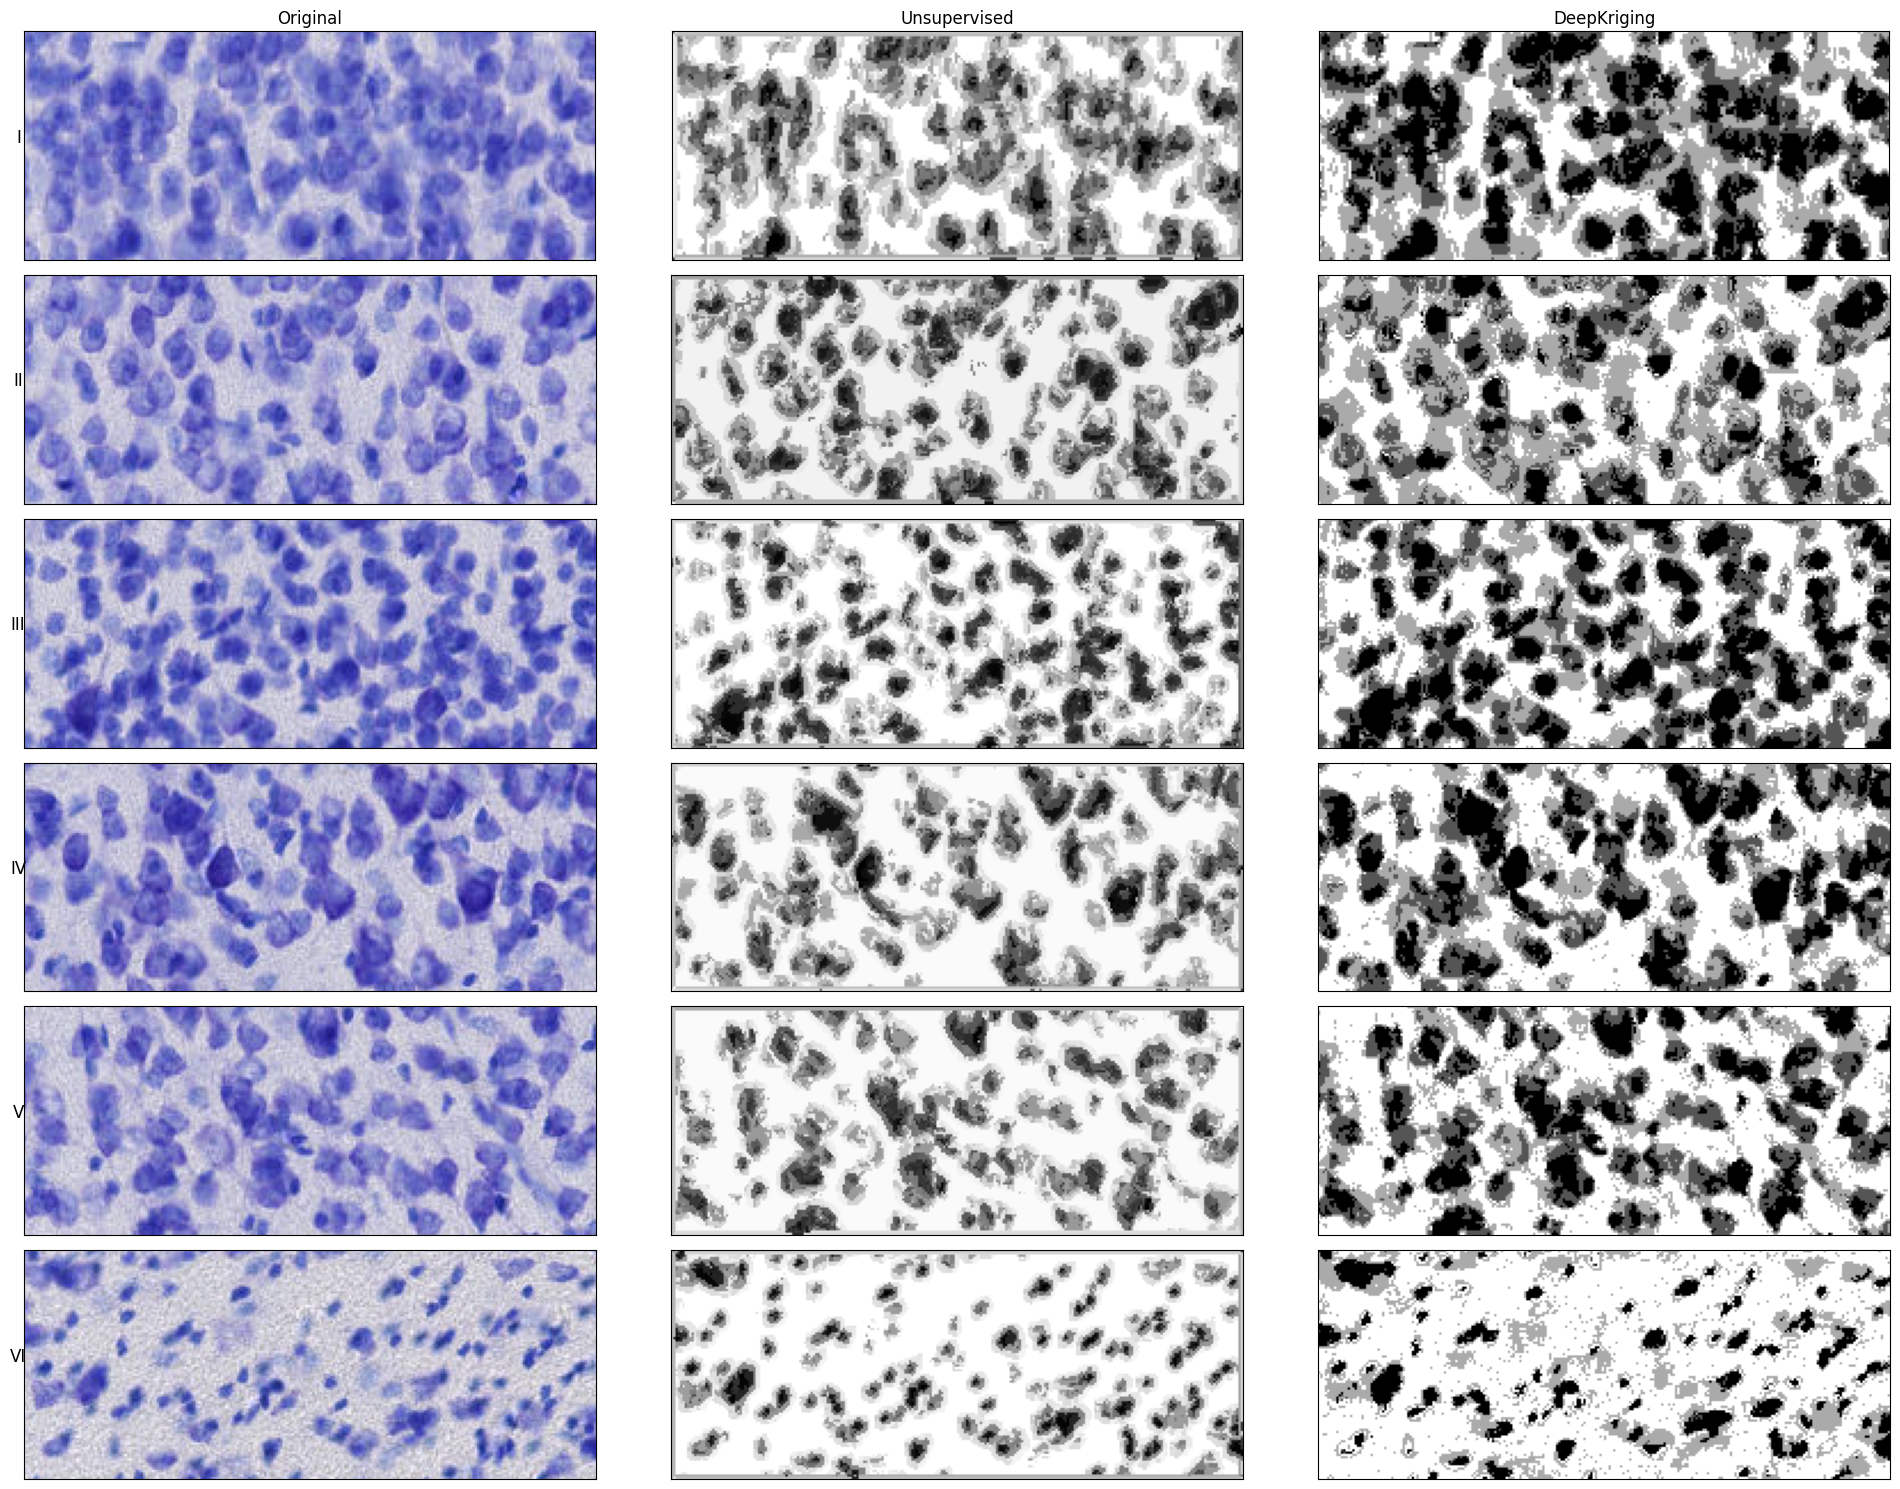

In [6]:
figs, axes = plt.subplots(6, 3, figsize=(20, 15))
plt.setp(axes, xticks=[], yticks=[])

axes[0, 0].set_title('Original')
axes[0, 1].set_title('Unsupervised')
axes[0, 2].set_title('DeepKriging')

axes[0, 0].set_ylabel('I', rotation=0, size='large')
axes[1, 0].set_ylabel('II', rotation=0, size='large')
axes[2, 0].set_ylabel('III', rotation=0, size='large')
axes[3, 0].set_ylabel('IV', rotation=0, size='large')
axes[4, 0].set_ylabel('V', rotation=0, size='large')
axes[5, 0].set_ylabel('VI', rotation=0, size='large')

for i in range(6):
    r = regions[i]
    axes[i, 0].imshow(img[r[0][0]:r[0][1], r[1][0]:r[1][1]])

for i in range(6):
    r = regions[i]
    axes[i, 1].imshow(seg_dl(img[r[0][0]:r[0][1], r[1][0]:r[1][1]]), cmap='gray')

for i in range(6):
    r = regions[i]
    axes[i, 2].imshow(seg_dk(img[r[0][0]:r[0][1], r[1][0]:r[1][1]]), cmap='gray')

figs.tight_layout()